## Intro

This notebook demonstrates the feature engineering process for our donation data.

The process is broken into a few sections:
* **Query** - Load the data using sql alchemy.
  * We only load data from the 2015 cycle to make our calculations run fast, but its straightforward to pull more years.
* **EDA** - Explore some of the features we have. 
  * Not absolutely necessary, but often useful to understand what tools (dataset variables) are available to work with. 
  * Our donation data only has one numeric column (transaction_amount), the rest are categorical... so we can mainly work with subsets of transaction_amount grouping by categorical features, or do counts.
* **Feature Engineering** - Create some features and tie them together in a dataframe (df_features)
  * Note that our donation data is transactions (donation per donor per recipient per election), while our features are aggregated around recipient per election

To practice, the feature engineering section has enough to get started. However it often helps to explore the data a bit first.

## Package Imports

In [79]:
import os
import sys
import math
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_columns = 999
import sqlalchemy as sqla
from sqlalchemy import create_engine
import pprint

# Setup SQL link
# See onboarding materials for the connection path stored in CD_DWH 
DB_URI = os.getenv('CD_DWH')
engine = create_engine(DB_URI)

## Query

### Check election cycles in data

In [80]:
QUERY = """
select distinct election_cycle
from trg_analytics.candidate_contributions
--where election_cycle >= '2015'
"""
with engine.begin() as conn:
    df_temp = pd.read_sql(QUERY, conn)
    
df_temp.sort_values("election_cycle")

,election_cycle
2,2001
4,2003
0,2005
3,2007
7,2009
1,2011
6,2013
5,2015
8,2017


### Pull 2015 cycle

In [81]:
QUERY = """
select *
from trg_analytics.candidate_contributions
where election_cycle = '2015'
"""
with engine.begin() as conn:
    df_full = pd.read_sql(QUERY, conn)

In [82]:
df_full.head(10)

,transaction_id,transaction_type,election_cycle,election,primary_general_indicator,transaction_date,transaction_amount,filed_date,recipient_committee_name,recipient_candidate_name,recipient_candidate_party,recipient_candidate_ico,recipient_candidate_status,recipient_candidate_office,recipient_candidate_district,donor_name,donor_city,donor_state,donor_zip_code,donor_employer,donor_occupation,donor_organization,donor_industry,donor_entity_type,donor_committee_id,donor_committee_name,donor_committee_type,donor_committee_party
0,2131595 - 6,Loan,2015,2014-11-04,0,2014-07-31,0.0,2017-01-31,"KROUSE FOR ASSEMBLY 2014, THOMAS","KROUSE, THOMAS",NOT CURRENTLY SUPPORTED,None,NOT CURRENTLY SUPPORTED,State Assembly,76.0,"Krouse, Thomas",Carlsbad,CA,92011,Konodomo Group/Marketocracy,NOT CURRENTLY SUPPORTED,IND,0,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,None,None
1,2131595 - 7,Loan,2015,2014-11-04,0,2014-08-22,0.0,2017-01-31,"KROUSE FOR ASSEMBLY 2014, THOMAS","KROUSE, THOMAS",NOT CURRENTLY SUPPORTED,None,NOT CURRENTLY SUPPORTED,State Assembly,76.0,"Krouse, Thomas",Carlsbad,CA,92011,Konodomo Group/Marketocracy,NOT CURRENTLY SUPPORTED,IND,0,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,None,None
2,2131595 - 8,Loan,2015,2014-11-04,0,2014-09-12,0.0,2017-01-31,"KROUSE FOR ASSEMBLY 2014, THOMAS","KROUSE, THOMAS",NOT CURRENTLY SUPPORTED,None,NOT CURRENTLY SUPPORTED,State Assembly,76.0,"Krouse, Thomas",Carlsbad,CA,92011,Konodomo Group/Marketocracy,NOT CURRENTLY SUPPORTED,IND,0,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,None,None
3,2131595 - 9,Loan,2015,2014-11-04,0,2014-09-17,0.0,2017-01-31,"KROUSE FOR ASSEMBLY 2014, THOMAS","KROUSE, THOMAS",NOT CURRENTLY SUPPORTED,None,NOT CURRENTLY SUPPORTED,State Assembly,76.0,"Krouse, Thomas",Carlsbad,CA,92011,Konodomo Group/Marketocracy,NOT CURRENTLY SUPPORTED,IND,0,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,None,None
4,2131595 - 10,Loan,2015,2014-11-04,0,2014-09-29,0.0,2017-01-31,"KROUSE FOR ASSEMBLY 2014, THOMAS","KROUSE, THOMAS",NOT CURRENTLY SUPPORTED,None,NOT CURRENTLY SUPPORTED,State Assembly,76.0,"Krouse, Thomas",Carlsbad,CA,92011,Konodomo Group/Marketocracy,NOT CURRENTLY SUPPORTED,IND,0,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,None,None
5,2131595 - 11,Loan,2015,2014-11-04,0,2014-10-03,0.0,2017-01-31,"KROUSE FOR ASSEMBLY 2014, THOMAS","KROUSE, THOMAS",NOT CURRENTLY SUPPORTED,None,NOT CURRENTLY SUPPORTED,State Assembly,76.0,"Krouse, Thomas",Carlsbad,CA,92011,Konodomo Group/Marketocracy,NOT CURRENTLY SUPPORTED,IND,0,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,None,None
6,2131595 - 13,Loan,2015,2014-11-04,0,2014-10-28,0.0,2017-01-31,"KROUSE FOR ASSEMBLY 2014, THOMAS","KROUSE, THOMAS",NOT CURRENTLY SUPPORTED,None,NOT CURRENTLY SUPPORTED,State Assembly,76.0,"Krouse, Thomas",Carlsbad,CA,92011,Konodomo Group/Marketocracy,NOT CURRENTLY SUPPORTED,IND,0,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,None,None
7,2131608 - B1-3248,Loan,2015,None,0,2016-10-21,0.0,2017-01-31,Lackey for Assembly 2016,"LACKEY, THOMAS W.",NOT CURRENTLY SUPPORTED,None,NOT CURRENTLY SUPPORTED,State Assembly,36.0,Waldron for Assembly 2016,San Diego,CA,92119,None,NOT CURRENTLY SUPPORTED,COM,1374375,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,None,None
8,2131614 - B1-4488,Loan,2015,None,0,2016-04-22,0.0,2017-01-31,Young Kim for Assembly 2016,"KIM, YOUNG O.",NOT CURRENTLY SUPPORTED,None,NOT CURRENTLY SUPPORTED,State Assembly,65.0,Brian Dahle for Assembly 2016,Hilmar,CA,95324,None,NOT CURRENTLY SUPPORTED,COM,1373730,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,None,None
9,2131614 - B1-5429,Loan,2015,None,0,2016-09-09,0.0,2017-01-31,Young Kim for Assembly 2016,"KIM, YOUNG O.",NOT CURRENTLY SUPPORTED,None,NOT CURRENTLY SUPPORTED,State Assembly,65.0,Devon Mathis for Assembly 2016,Visalia,CA,93291,N

In [83]:
print (df_full.info()) 
df_full.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159079 entries, 0 to 159078
Data columns (total 28 columns):
transaction_id                  159079 non-null object
transaction_type                159079 non-null object
election_cycle                  159079 non-null object
election                        106491 non-null object
primary_general_indicator       159079 non-null int64
transaction_date                159013 non-null object
transaction_amount              159079 non-null float64
filed_date                      159079 non-null object
recipient_committee_name        159079 non-null object
recipient_candidate_name        159078 non-null object
recipient_candidate_party       159079 non-null object
recipient_candidate_ico         0 non-null object
recipient_candidate_status      159079 non-null object
recipient_candidate_office      159079 non-null object
recipient_candidate_district    137229 non-null object
donor_name                      159079 non-null object
donor_city    

,transaction_id,transaction_type,election_cycle,election,primary_general_indicator,transaction_date,transaction_amount,filed_date,recipient_committee_name,recipient_candidate_name,recipient_candidate_party,recipient_candidate_ico,recipient_candidate_status,recipient_candidate_office,recipient_candidate_district,donor_name,donor_city,donor_state,donor_zip_code,donor_employer,donor_occupation,donor_organization,donor_industry,donor_entity_type,donor_committee_id,donor_committee_name,donor_committee_type,donor_committee_party
count,159079,159079,159079,106491,159079.0,159013,159079.000000,159079,159079,159078,159079,0.0,159079,159079,137229,159079,159011,158977,158984,73059,159079,159079,159079,159079,159079,159079,0.0,0.0
unique,159079,4,1,49,NaN,968,NaN,371,555,398,1,0.0,1,14,171,69702,3018,89,10973,31643,1,6,1931,1,1,1,0.0,0.0
top,2006169 - A157,Monetary Contribution,2015,2016-06-07,NaN,2015-06-30,NaN,2016-02-01,Newsom for California Governor 2018,"NEWSOM, GAVIN",NOT CURRENTLY SUPPORTED,NaN,NOT CURRENTLY SUPPORTED,State Assembly,11.0,California Democratic Party,Sacramento,CA,95814,None,NOT CURRENTLY SUPPORTED,IND,0,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,NOT CURRENTLY SUPPORTED,NaN,NaN
freq,1,151199,159079,53249,NaN,3747,NaN,17847,10468,10468,159079,NaN,159079,78858,4914,2036,25237,143781,15235,4019,159079,86552,121559,159079,159079,159079,NaN,NaN
mean,NaN,NaN,NaN,NaN,0.0,NaN,1365.995727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,0.0,NaN,4659.507634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,0.0,NaN,-175000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,0.0,NaN,120.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,0.0,NaN,500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,0.0,NaN,1500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Drop null columns

In [84]:
null_columns = ["recipient_candidate_party", "recipient_candidate_ico", "recipient_candidate_status",
                "donor_occupation", "donor_entity_type", "donor_committee_id", "donor_committee_name",
                "donor_committee_type", "donor_committee_party"]

df = df_full.drop(columns=null_columns,inplace=False)
df.head()

def string_element_lower(element):
    if type(element) == str:
        return element.lower()
    else:
        return element
    
df = df.applymap(string_element_lower)

In [85]:
df.head(5)

,transaction_id,transaction_type,election_cycle,election,primary_general_indicator,transaction_date,transaction_amount,filed_date,recipient_committee_name,recipient_candidate_name,recipient_candidate_office,recipient_candidate_district,donor_name,donor_city,donor_state,donor_zip_code,donor_employer,donor_organization,donor_industry
0,2131595 - 6,loan,2015,2014-11-04,0,2014-07-31,0.0,2017-01-31,"krouse for assembly 2014, thomas","krouse, thomas",state assembly,76.0,"krouse, thomas",carlsbad,ca,92011,konodomo group/marketocracy,ind,0
1,2131595 - 7,loan,2015,2014-11-04,0,2014-08-22,0.0,2017-01-31,"krouse for assembly 2014, thomas","krouse, thomas",state assembly,76.0,"krouse, thomas",carlsbad,ca,92011,konodomo group/marketocracy,ind,0
2,2131595 - 8,loan,2015,2014-11-04,0,2014-09-12,0.0,2017-01-31,"krouse for assembly 2014, thomas","krouse, thomas",state assembly,76.0,"krouse, thomas",carlsbad,ca,92011,konodomo group/marketocracy,ind,0
3,2131595 - 9,loan,2015,2014-11-04,0,2014-09-17,0.0,2017-01-31,"krouse for assembly 2014, thomas","krouse, thomas",state assembly,76.0,"krouse, thomas",carlsbad,ca,92011,konodomo group/marketocracy,ind,0
4,2131595 - 10,loan,2015,2014-11-04,0,2014-09-29,0.0,2017-01-31,"krouse for assembly 2014, thomas","krouse, thomas",state assembly,76.0,"krouse, thomas",carlsbad,ca,92011,konodomo group/marketocracy,ind,0


In [86]:
print (df.info()) 
df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159079 entries, 0 to 159078
Data columns (total 19 columns):
transaction_id                  159079 non-null object
transaction_type                159079 non-null object
election_cycle                  159079 non-null object
election                        106491 non-null object
primary_general_indicator       159079 non-null int64
transaction_date                159013 non-null object
transaction_amount              159079 non-null float64
filed_date                      159079 non-null object
recipient_committee_name        159079 non-null object
recipient_candidate_name        159078 non-null object
recipient_candidate_office      159079 non-null object
recipient_candidate_district    137229 non-null object
donor_name                      159079 non-null object
donor_city                      159011 non-null object
donor_state                     158977 non-null object
donor_zip_code                  158984 non-null object
donor_emp

,transaction_id,transaction_type,election_cycle,election,primary_general_indicator,transaction_date,transaction_amount,filed_date,recipient_committee_name,recipient_candidate_name,recipient_candidate_office,recipient_candidate_district,donor_name,donor_city,donor_state,donor_zip_code,donor_employer,donor_organization,donor_industry
count,159079,159079,159079,106491,159079.0,159013,159079.000000,159079,159079,159078,159079,137229,159079,159011,158977,158984,73059,159079,159079
unique,159079,4,1,49,NaN,968,NaN,371,552,398,14,171,67835,2411,74,10973,31068,6,1931
top,2120709 - inc2446,monetary contribution,2015,2016-06-07,NaN,2015-06-30,NaN,2016-02-01,newsom for california governor 2018,"newsom, gavin",state assembly,11.0,california democratic party,sacramento,ca,95814,none,ind,0
freq,1,151199,159079,53249,NaN,3747,NaN,17847,10468,10468,78858,4914,2037,25970,143949,15235,4403,86552,121559
mean,NaN,NaN,NaN,NaN,0.0,NaN,1365.995727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,0.0,NaN,4659.507634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,0.0,NaN,-175000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,0.0,NaN,120.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,0.0,NaN,500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,0.0,NaN,1500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA

### Count unique values per feature

In [87]:
column_data = []

for column in df.columns:
    uniques = df[column].unique()
    column_data.append((column, len(uniques), uniques))
    
column_data.sort(key=lambda x: x[1])

# Print feature - unique values
# pprint.pprint([("{:28} - {:6} unique".format(x[0],x[1])) for x in column_data])

# Print feature - unique values - example values (up to 1 line)
for x in column_data:
    print ("{:28} - {:6} unique {:.55}".format(x[0],x[1],str(x[2])))

election_cycle               -      1 unique ['2015']
primary_general_indicator    -      1 unique [0]
transaction_type             -      4 unique ['loan' 'late contribution' 'monetary contribution'
 'n
donor_organization           -      6 unique ['ind' 'com' 'oth' 'scc' 'pty' 'rcp']
recipient_candidate_office   -     14 unique ['state assembly' 'state senate' 'board of equalization
election                     -     50 unique [datetime.date(2014, 11, 4) None datetime.date(2016, 11
donor_state                  -     75 unique ['ca' 'ks' 'il' 'co' 'az' 'mi' 'sc' 'oh' 'nd' 'tn' 'nc'
recipient_candidate_district -    172 unique ['76.0' '36.0' '65.0' '66.0' '12.0' '6.0' '72.0' '3.0' 
filed_date                   -    371 unique [datetime.date(2017, 1, 31) datetime.date(2017, 2, 1)
 
recipient_candidate_name     -    399 unique ['krouse, thomas' 'lackey, thomas w.' 'kim, young o.' '
recipient_committee_name     -    552 unique ['krouse for assembly 2014, thomas' 'lackey for assembl
transa

### Transaction Amount
There are negative donations & extremely large ones (up to 400k). Need to check what the donation limits are.

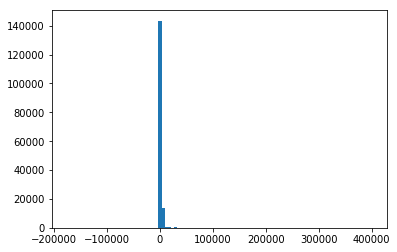

In [88]:
# All donations
plt.hist(df.transaction_amount, bins=100)
plt.show()

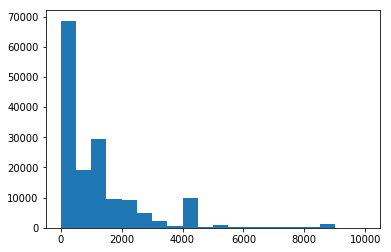

In [89]:
# Donations $0-10k
plt.hist(df[(df.transaction_amount>=0)&(df.transaction_amount<10000)].transaction_amount, bins=20)
plt.show()

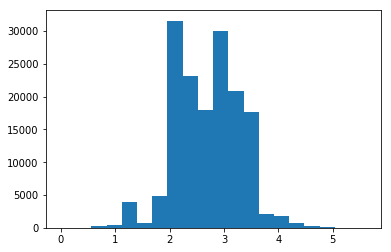

In [90]:
# Donations $1+, log bins
plt.hist(np.log10(df[(df.transaction_amount>=1)].transaction_amount), bins=20)
plt.show()

In [91]:
print(len(df[df.transaction_amount < 0]))
df[df.transaction_amount < 0].sort_values("transaction_amount").head()

691


,transaction_id,transaction_type,election_cycle,election,primary_general_indicator,transaction_date,transaction_amount,filed_date,recipient_committee_name,recipient_candidate_name,recipient_candidate_office,recipient_candidate_district,donor_name,donor_city,donor_state,donor_zip_code,donor_employer,donor_organization,donor_industry
106088,2064450 - exp2681,monetary contribution,2015,2016-06-07,0,2016-06-30,-175000.0,2016-08-01,anthony portantino for senate 2016,"portantino, anthony",state senate,25,anthony portantino congressional exploratory c...,long beach,ca,90802,None,com,0
120426,2083449 - exp1175,monetary contribution,2015,2016-06-07,0,2016-09-23,-100000.0,2016-09-29,marc steinorth for assembly 2016,"steinorth, marc",state assembly,40,ca republican party,burbank,ca,91506,None,pty,810163
148464,2130596 - inc371,monetary contribution,2015,2018-06-05,0,2016-12-27,-24000.0,2017-01-31,villaraigosa for governor 2018,"villaraigosa, antonio",governor,None,"nunez, fabian",los angeles,ca,90046,mercury,ind,0
148461,2130596 - inc384,monetary contribution,2015,2018-06-05,0,2016-12-29,-13500.0,2017-01-31,villaraigosa for governor 2018,"villaraigosa, antonio",governor,None,"nazarian, younes",los angeles,ca,90067,nazarian enterprises,ind,0
61357,2013133 - idt11212,monetary contribution,2015,None,0,2015-11-01,-10000.0,2017-01-30,newsom for california governor 2018,"newsom, gavin",governor,None,"siegel, john",louisville,ky,40205,"bowie resource partners, llc",ind,0


In [92]:
print(len(df[df.transaction_amount > 50000]))
df[df.transaction_amount > 50000].sort_values("transaction_amount",ascending=False).head()

184


,transaction_id,transaction_type,election_cycle,election,primary_general_indicator,transaction_date,transaction_amount,filed_date,recipient_committee_name,recipient_candidate_name,recipient_candidate_office,recipient_candidate_district,donor_name,donor_city,donor_state,donor_zip_code,donor_employer,donor_organization,donor_industry
132010,2097901 - inc1227,monetary contribution,2015,2016-06-07,0,2016-10-17,400000.0,2016-10-27,ling ling chang for senate 2016,"chang, ling-ling",state senate,29.0,republican party of san luis obispo county,san luis obispo,ca,93401,None,pty,841621
139817,2098699 - a-5694,monetary contribution,2015,2016-11-08,0,2016-10-06,300000.0,2016-10-27,young kim for assembly 2016,"kim, young o.",state assembly,65.0,california republican party,sacramento,ca,95814-3970,None,pty,810163
147706,2130229 - vnw37ext3p5,monetary contribution,2015,None,0,2016-10-25,300000.0,2017-05-01,muratsuchi for assembly 2016,"muratsuchi, al",state assembly,66.0,california democratic party,sacramento,ca,95811-7012,None,pty,741666
149960,2130887 - non1273,non-monetary contribution,2015,None,0,2016-10-24,289048.5,2017-01-31,cook-kallio for assembly 2016,"cook-kallio, cheryl",state assembly,16.0,california democratic party,sacramento,ca,95811,None,pty,741666
157103,1983218 - pay1486,loan,2015,2016-06-07,0,2015-06-30,275000.0,2016-01-24,anthony portantino for senate 2016,"portantino, anthony",state senate,25.0,anthony portantino congressional exploratory c...,long beach,ca,90802,None,com,0


### Donor state
There are more than 50 values for donor state

In [93]:
print (sum(df.donor_state.value_counts()[50:]))
df.donor_state.value_counts()[50:]

44


95    5
sa    4
ae    4
pr    3
c     3
vi    3
bc    2
gb    2
a     2
on    2
cs    1
`c    1
pn    1
rj    1
gu    1
cv    1
ho    1
uc    1
ms    1
cf    1
uk    1
da    1
cc    1
go    1
Name: donor_state, dtype: int64

### Transaction Type

In [94]:
df.groupby("transaction_type")\
    .agg({"transaction_amount":["sum","count","mean","max"]})\
    .sort_values(("transaction_amount","sum"),ascending=False)

transaction_amount                               
                                         sum   count         mean       max
transaction_type                                                           
monetary contribution           1.873920e+08  151199  1239.372960  400000.0
non-monetary contribution       2.520266e+07    5450  4624.342156  289048.5
loan                            4.697116e+06    2427  1935.358986  275000.0
late contribution               9.501130e+03       3  3167.043333    8500.0

### Donor Organization

In [95]:
df.groupby("donor_organization")\
    .agg({"transaction_amount":["sum","count","mean","max"]})\
    .sort_values(("transaction_amount","sum"),ascending=False)

transaction_amount                               
                                  sum  count          mean       max
donor_organization                                                  
ind                       58781330.38  86552    679.144680  100000.0
oth                       51705878.57  34361   1504.783870   50000.0
com                       44599101.00  27174   1641.241665  275000.0
pty                       36602005.87   2988  12249.667293  400000.0
scc                       24932241.17   7582   3288.346237   28200.0
rcp                         680677.29    422   1612.979360    8500.0

### Recipient Office

In [96]:
df.groupby("recipient_candidate_office")\
    .agg({"transaction_amount":["sum","count","mean","max"]})\
    .sort_values(("transaction_amount","sum"),ascending=False)

transaction_amount                      \
                                                    sum  count         mean   
recipient_candidate_office                                                    
state assembly                             1.142977e+08  78858  1449.411549   
state senate                               6.648362e+07  53116  1251.668491   
governor                                   1.667507e+07  12744  1308.464269   
other                                      6.125730e+06   4394  1394.112497   
lieutenant governor                        5.403710e+06   3596  1502.700336   
state treasurer                            2.719735e+06   2426  1121.077902   
board of equalization                      1.732530e+06   1360  1273.919140   
attorney general                           1.351202e+06    965  1400.209264   
insurance commissioner                     9.737423e+05    651  1495.763978   
state controller                           6.536391e+05    361  1810.634598   
secretary of state                         5.308169e+05    290  1830.403000   
city council member                        3.078300e+05    286  1076.328671   
superintendent of public instruction       3.246795e+04     20  1623.397500   
board of supervisors                       1.344220e+04     12  1120.183333   

                                                
                                           max  
recipient_candidate_office                      
state assembly                        300000.0  
state senate                          400000.0  
governor                               29200.0  
other                                  60000.0  
lieutenant governor                    14100.0  
state treasurer                        14100.0  
board of equalization                  60000.0  
attorney general                       14100.0  
insurance commissioner                  8200.0  
state controller                       14100.0  
secretary of state                     14100.0  
city council member                     8500.0  
superintendent of public instruction    6800.0  
board of supervisors                    4200.0

## Feature Engineering

This section contains the workflow for feature engineering.

A new dataframe (df_features) will hold our engineered features. This data frame should have one row per candidate per election (contrast with our donation dataframe (df) which has one row per donation).

The following cells will initialize df_features with basic stats on donations, and then engineer & merge a few additional features. Try to think of more features and build them in!  

### Base donation stats
Start out with basic stats on donations (total $, # donations, avg donation, max donation)

In [97]:
key_columns = ["recipient_candidate_name","election_cycle"]
base_features = ["donation_sum", "donation_count", "donation_mean", "donation_max"]

df_features = (df.groupby(["recipient_candidate_name","election_cycle"],as_index=False)
                 .agg({"transaction_amount":["sum","count","mean","max"]}))

df_features.columns = key_columns + base_features
df_features.head()

,recipient_candidate_name,election_cycle,donation_sum,donation_count,donation_mean,donation_max
0,"achadjian, khatchik",2015,40500.00,23,1760.869565,4200.0
1,"acosta, dante",2015,987814.08,383,2579.149034,108415.0
2,"acosta, georgia l.",2015,15750.00,26,605.769231,4200.0
3,"aguiar-curry, cecilia",2015,501513.93,522,960.754655,8500.0
4,"albert-sheridan, lenore l.",2015,6100.00,6,1016.666667,2000.0


### Add feature example
Here's an example of creating a new feature, then merging it into the base features.

In [98]:
# First, create new feature... sum and count of small $ donations
# <$200 is the poli-sci definition - https://wpt.org/Here_and_Now/role-small-donations-2016-presidential-election

# Feature names
new_features = ['small_donation_sum','small_donation_count']

# Aggregate the feature
df_new_features = (df[df.transaction_amount < 200].groupby(["recipient_candidate_name","election_cycle"], as_index=False)
                                                  .agg({"transaction_amount":["sum","count"]}))

# Name the feature columns (replacing multi-index which groupby.agg generates)
df_new_features.columns = key_columns+new_features

# Check if it worked
df_new_features.head()

,recipient_candidate_name,election_cycle,small_donation_sum,small_donation_count
0,"acosta, dante",2015,7949.59,75
1,"acosta, georgia l.",2015,550.00,5
2,"aguiar-curry, cecilia",2015,18038.50,211
3,"albert-sheridan, lenore l.",2015,100.00,1
4,"alejo, luis",2015,2998.90,21


In [99]:
# Second, merge it into df_features

# Dataframe.merge() works like a SQL join. Inner join by default, but can specify other types
df_features = df_features.merge(df_new_features, on=key_columns)

# Check if it worked
df_features.head()

,recipient_candidate_name,election_cycle,donation_sum,donation_count,donation_mean,donation_max,small_donation_sum,small_donation_count
0,"acosta, dante",2015,987814.08,383,2579.149034,108415.0,7949.59,75
1,"acosta, georgia l.",2015,15750.00,26,605.769231,4200.0,550.00,5
2,"aguiar-curry, cecilia",2015,501513.93,522,960.754655,8500.0,18038.50,211
3,"albert-sheridan, lenore l.",2015,6100.00,6,1016.666667,2000.0,100.00,1
4,"alejo, luis",2015,327940.50,196,1673.165816,90000.0,2998.90,21
